# **Denoising Diffusion Implicit Models - DDIM**

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc
import numpy as np
import matplotlib as mpl, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

In [2]:
from fastprogress.fastprogress import progress_bar

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [5]:
# Given that we have built the entire DDPM pipeline from scratch,
# using the HF diffusers library for the pre-built pipeline is now allowed
from diffusers import UNet2DModel, DDPMPipeline, DDPMScheduler, DDIMPipeline, DDIMScheduler

When implementing [DDIM](https://arxiv.org/abs/2010.02502), we won't need to retain our model and will be working on optimizing and / or modifying the de-noising and sampling steps to speed up the inference process. The paper summary states:

> (DDPMs) require simulating a Markov chain for many steps to produce a sample. To accelerate sampling, we present denoising diffusion implicit models (DDIMs), a more efficient class of iterative implicit probabilistic models with the same training procedure as DDPMs.
>
> In DDPMs, the generative process is defined as the reverse of a Markovian diffusion process. We construct a class of non-Markovian diffusion processes that lead to the same training objective, but whose reverse process can be much faster to sample from. We empirically demonstrate that DDIMs can produce high quality samples 10× to 50× faster in terms of wall-clock time compared to DDPMs, allow us to trade off computation for sample quality, and can perform semantically meaningful image interpolation directly in the latent space. 


## **Pre-Built Diffusers DDPM Scheduler**

In [6]:
class UNet(UNet2DModel): pass

In [8]:
model = torch.load('models/fashion_ddpm3_25.pkl').cuda()

In [9]:
sched = DDPMScheduler(beta_end=0.01)

In [10]:
x_t = torch.randn((32, 1, 32, 32)).cuda()

In [11]:
t = 999
t_batch = torch.full((len(x_t), ), t, device=x_t.device, dtype=torch.long)

with torch.no_grad(): noise = model(x_t, t_batch).sample

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [12]:
res = sched.step(noise, t, x_t)

In [13]:
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [14]:
sz = (2048, 1, 32, 32)

In [15]:
%%time 
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())    

CPU times: user 22min 56s, sys: 16 s, total: 23min 12s
Wall time: 24min 59s


In [16]:
s = preds[-1].clamp(-0.5, 0.5)*2

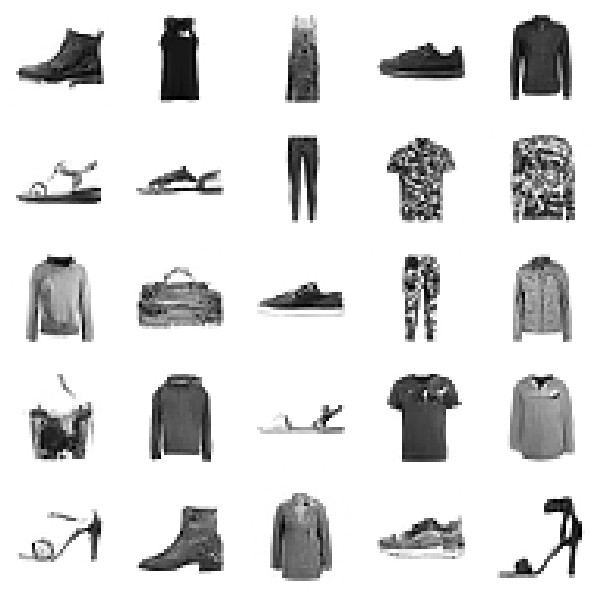

In [17]:
show_images(s[:25], imsize=1.5)

In [18]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [ ]:
clean_mem()

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(0), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb, yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
ie.fid(s), ie.kid(s)

In [ ]:
ie.fid(xb), ie.kid(xb)

## **Pre-Built Diffusers DDIM Scheduler**

In [ ]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [ ]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1, 1)

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s), ie.kid(s)

In [ ]:
sched.set_timesteps(200)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1, 1)
ie.fid(s), ie.kid(s)

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(100)
preds = diff_sample(model, sz, sched, eta=1.)

In [ ]:
s = (preds[-1]*2).clamp(-1, 1)

In [ ]:
ie.fid(s), ie.kid(s)

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(50)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
sched.set_timesteps(25)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

In [ ]:
show_images(s[:25], imsize=1.5)